In [3]:
%matplotlib inline
import pandas as pd
import IGtools as igt
import networkx as nx
import os, sys 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

In [5]:
import igraph as ig

In [6]:
def plot_results(x,data,norm=None,label=None,marker='s'):
    yy = map(lambda x: np.mean(data[x]), sorted(data.keys()));
    std_yy = map(lambda x: np.std(data[x]), sorted(data.keys()));
    plt.gca()
    if norm==None:
        plt.errorbar(x, np.array(yy), np.array(std_yy), fmt=marker,ms=10,alpha=0.6, label=label);
    else:
        plt.errorbar(x, np.array(yy)/float(norm), np.array(std_yy)/float(norm), fmt=marker,ms=10,alpha=0.6, label=label);
    return;

In [10]:
from scipy.optimize import fsolve, fmin, root
import sympy as sy
from mis_utils import *

# Simulation-driven comparison with IG 

In [11]:
####### analytical functions for Gaussian degree distributions 
def attempt_scipy_func_gauss(x, d,sigma, c):
    return np.abs(x - np.power(1 - ((sigma*sigma*np.log(x)+d)/float(d*x)) * np.exp((d*np.log(x) + 0.5*sigma*sigma*np.power(np.log(x),2))), c-1));


def minimize_gauss_pstar(xs, d, sigma, c):
    vals = map(lambda x: attempt_scipy_func_gauss(x, d, sigma, c), xs);
    x0 = (np.min(vals), xs[np.nanargmin(vals)])
    return x0[1]

def rho_gauss(x,d,sigma,c):
    ed01dp0 = (1 - d - sigma*sigma*np.log(x)) * np.exp(d*np.log(x) + 0.5*sigma*sigma*np.log(x)*np.log(x))
    return (d/c)  * (1 - np.power(x,c/float(c-1))) + (ed01dp0);

def gaussian_prediction(ps,sigmas,xs=None,c=2):
#    if xs == None:
#        xs = np.linspace(0,1,1000);
    import time 
    now = time.time()
    rho_stars_gauss = []
    for i,d in enumerate(ps):
        p_stars_gauss = minimize_gauss_pstar(xs, d , sigmas[i], c);
        rho_stars_gauss.append(rho_gauss(p_stars_gauss, d , sigmas[i], c));
    return rho_stars_gauss;


In [12]:
num_iter = 10;
nN = 20;
xs = np.linspace(0, 1, 2000); #lazy xs

new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_gauss_pred = {}
dens = {}

In [13]:
import time
from datetime import datetime

import igraph as igg
new_k_min = 1
new_k_max = 15
new_pmin = new_k_min/float(nN);
new_pmax = new_k_max/float(nN);
precision = 10
new_ps = np.linspace(new_pmin,new_pmax,precision);

from scipy.stats import norm

for l,p in tqdm_notebook(enumerate(new_ps)):
    print l, '/', precision, ':', len(new_ps), 'started:', str(datetime.now())
    new_gauss_pred[p] = []
    new_res_ig[p] = []
    new_av_k_ig[p] = [];
    new_n_ig_dict[p] = []
    dens[p] = []
    for it in range(num_iter):
        g = igt.create_ER_bipartite_graph(nN,p) # create ER bipartite graph
        lg = igt.line_graph(g) # create line graph
        ig = igt.interference_graph(lg) # create interference graph
        ig_degs = ig.degree().values()
        new_av_k_ig[p].append(np.mean(ig_degs)); # computed z
        new_n_ig = ig.number_of_nodes() # compute number of tasks M
        new_n_ig_dict[p].append(new_n_ig); # compute number of tasks M
        nx.write_gml(ig,'test.gml'); #horrible trick
        g_igraph = igg.load('test.gml') 
        new_res_ig[p].append( g_igraph.alpha() )  # empirical/real MIS size
#         mu = np.mean(g.degree().values()); # mean 
#         sigma =  np.std(g.degree().values());
        mu = new_av_k_ig[p][-1]
        sigma = np.std(ig_degs)
        p_stars_gauss = minimize_gauss_pstar(xs, mu, sigma, 2); #prediction based on gaussian IG degree distribution
        new_gauss_pred[p].append(rho_gauss(p_stars_gauss, mu , sigma, 2)); #prediction based on gaussian IG degree distribution
        dens[p].append(nx.density(ig));

0 / 10 : 10 started: 2019-10-23 09:54:43.189774


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


1 / 10 : 10 started: 2019-10-23 09:54:43.433253


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


2 / 10 : 10 started: 2019-10-23 09:54:44.779513


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


3 / 10 : 10 started: 2019-10-23 09:54:52.589666
4 / 10 : 10 started: 2019-10-23 09:55:21.138318
5 / 10 : 10 started: 2019-10-23 09:56:03.596265
6 / 10 : 10 started: 2019-10-23 09:57:00.974421
7 / 10 : 10 started: 2019-10-23 09:57:59.178148
8 / 10 : 10 started: 2019-10-23 09:59:01.054793
9 / 10 : 10 started: 2019-10-23 10:00:01.065638



In [14]:
cmap = plt.cm.hot
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

In [15]:
av_dens = [np.mean(dens[x]) for x in new_ps]

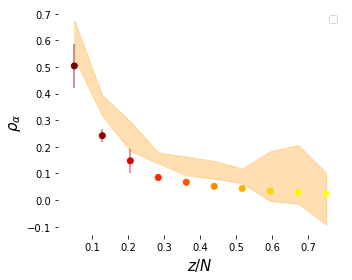

In [19]:
fs = 15
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)
data = new_gauss_pred
yy = np.array(map(lambda x: np.mean(data[x]), sorted(data.keys())));
std_yy = np.array(map(lambda x: np.std(data[x]), sorted(data.keys())));
plt.fill_between(new_ps,yy+std_yy,yy-std_yy, alpha=0.3,color=cmap(150))

data = new_res_ig
yy = map(lambda x: np.mean(np.array(data[x])/np.array(map(float,new_n_ig_dict[x]))), sorted(data.keys()));
std_yy = map(lambda x: np.std(np.array(data[x])/np.array(map(float,new_n_ig_dict[x]))), sorted(data.keys()));
plt.errorbar(new_ps,yy, std_yy, ms=0,alpha=0.4, color=cmap(av_dens),fmt='.',lw=2,mew=1.5)#,label = n_sigma)
plt.scatter(new_ps, yy, c=cmap(av_dens), vmin=0, vmax=1)
plt.ylabel(r'$\rho_\alpha$', fontsize=fs)
plt.xlabel(r'$z/N$', fontsize=fs)
plt.box('off')
plt.legend(loc=0)
plt.tight_layout()
plt.savefig('../submission/natphys-rebuttal/plots/MIS_IG_from_BG_densities.pdf')

In [17]:
# ###new bounds
# fs = 30
# fig = plt.figure(figsize=(8,8))
# data = new_gauss_pred
# yy = np.array(map(lambda x: np.mean(data[x]), sorted(data.keys())));
# std_yy = np.array(map(lambda x: np.std(data[x]), sorted(data.keys())));
# plt.fill_between(new_ps[:len(yy)],yy+std_yy,yy-std_yy, alpha=0.3,color=cmap(150), label='Pred. bounds')

# data = new_res_ig
# yy = map(lambda x: np.mean(data[x])/nN, sorted(data.keys()));
# std_yy = map(lambda x: np.std(data[x])/nN, sorted(data.keys()));
# plt.errorbar(new_ps[:len(yy)],yy,std_yy, ms=20,alpha=0.5,color=cmap(100),fmt='.',lw=2,mew=1.5,mec='k',label = r'Sim $\rho_\alpha$')
# plt.ylabel(r'$\rho_\alpha$', fontsize=fs)
# plt.xlabel(r'$\langle k \rangle/N$', fontsize=fs)
# plt.box('off')
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.legend(loc=0, fontsize=30)
# plt.ylim(0,1)
# plt.tight_layout()